In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # 直接使用 opencv，无需 PIL 兜底

In [35]:
def simple_2d_convolution_with_padding(image, kernel, padding=0):

    # 1. 对灰度图像进行零填充（上下左右各补 padding 个 0，保持图像边界信息）
    padded_image = np.pad(image, pad_width=padding, mode='constant', constant_values=0)

    # 2. 翻转卷积核（二维卷积核心要求：先上下翻转，再左右翻转，缺一不可）
    flipped_kernel = np.flipud(np.fliplr(kernel))  # 等价于 np.flip(kernel, axis=(0, 1))

    # 3. 获取尺寸信息，推导输出图像的高和宽
    img_h, img_w = padded_image.shape  # 填充后图像的高、宽
    ker_h, ker_w = flipped_kernel.shape  # 卷积核的高、宽
    output_h = img_h - ker_h + 1  # 输出图像的高
    output_w = img_w - ker_w + 1  # 输出图像的宽

    # 4. 初始化卷积结果数组，用 float32 存储避免计算精度丢失
    conv_result = np.zeros((output_h, output_w), dtype=np.float32)

    # 5. 滑动卷积核，逐位置执行「相乘求和」（二维卷积核心流程）
    for i in range(output_h):  # 遍历输出图像的每一行
        for j in range(output_w):  # 遍历输出图像的每一列
            # 截取当前滑动窗口对应的图像区域（ROI，感兴趣区域）
            img_roi = padded_image[i:i+ker_h, j:j+ker_w]
            # 逐元素相乘后求和，将结果存入卷积结果数组的对应位置
            conv_result[i, j] = np.sum(img_roi * flipped_kernel)

    # 6. 结果归一化（映射到 0-255 区间，转为 uint8 格式，方便可视化）
    conv_result = np.clip(conv_result, 0, 255)  # 限制数值范围，避免超出图像像素的合法区间
    if np.max(conv_result) > 0:  # 避免除以 0 错误（当卷积结果全为 0 时跳过归一化）
        conv_result = (conv_result / np.max(conv_result)) * 255
    conv_result = conv_result.astype(np.uint8)  # 转为 opencv 支持的图像像素格式（uint8）

    return conv_result

In [36]:
# 配置可视化字体，解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 环境，Mac 环境可改为 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False

# 读取图像（同时读取彩色原图和灰度图）
img_path = "../img/lena.jpeg"
# 读取彩色原图（OpenCV 默认读取为 BGR 格式，需转为 RGB 格式用于 matplotlib 显示）
lena_color = cv2.imread(img_path)
# 读取灰度图
lena_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 图像读取校验
if lena_color is None or lena_gray is None:
    raise Exception(f"图像读取失败！请确认：1. {img_path} 路径正确（img 文件夹存在且包含 lena.jpeg）；2. 文件未损坏；3. 后缀正确（jpeg/ jpg）")

# OpenCV BGR 转 matplotlib RGB 格式（彩色图必须转换，否则颜色失真）
lena_color_rgb = cv2.cvtColor(lena_color, cv2.COLOR_BGR2RGB)

print(f"OpenCV 图像读取成功！")
print(f"彩色原图形状：{lena_color.shape}（高×宽×通道数）")
print(f"灰度图形状：{lena_gray.shape}（高×宽）")
print(f"灰度图像素值范围：{np.min(lena_gray)} - {np.max(lena_gray)}")

OpenCV 图像读取成功！
彩色原图形状：(431, 789, 3)（高×宽×通道数）
灰度图形状：(431, 789)（高×宽）
灰度图像素值范围：14 - 223


In [37]:
# ------------------------------------------------------------------------------
# 步骤3：定义两种卷积核（边缘检测核 + 高斯模糊核），分别执行二维卷积
# ------------------------------------------------------------------------------

In [38]:
# 定义两种卷积核（边缘检测核 + 增强型高斯模糊核）
# 3x3 边缘检测卷积核
edge_kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
], dtype=np.float32)

# -------------------------- 核心修改：更换为5x5高模糊度高斯核 --------------------------
blur_kernel = np.array([
    [1,   4,   7,   10,  12,  10,  7,   4,   1],
    [4,   16,  26,  36,  44,  36,  26,  16,  4],
    [7,   26,  45,  63,  77,  63,  45,  26,  7],
    [10,  36,  63,  88,  107, 88,  63,  36,  10],
    [12,  44,  77,  107, 130, 107, 77,  44,  12],
    [10,  36,  63,  88,  107, 88,  63,  36,  10],
    [7,   26,  45,  63,  77,  63,  45,  26,  7],
    [4,   16,  26,  36,  44,  36,  26,  16,  4],
    [1,   4,   7,   10,  12,  10,  7,   4,   1]
], dtype=np.float32) / 1003  # 所有元素总和为1003，归一化保证权重和为1
# -------------------------------------------------------------------------------------

# 调整填充数（适配5x5卷积核，padding=2 使输出尺寸与原始图像一致，减少尺寸损失）
# 卷积核尺寸为 NxN 时，padding=(N-1)//2 可保证输入输出尺寸相同
padding_num = (blur_kernel.shape[0] - 1) // 2

# 执行二维卷积
# 边缘检测卷积
conv_edge = simple_2d_convolution_with_padding(
    image=lena_gray,
    kernel=edge_kernel,
    padding=1  # 3x3卷积核对应padding=1，保证尺寸匹配
)

# 高斯模糊卷积（使用5x5核+padding=2）
conv_blur = simple_2d_convolution_with_padding(
    image=lena_gray,
    kernel=blur_kernel,
    padding=padding_num
)

# 打印形状信息校验
print(f"原始灰度图形状：{lena_gray.shape}")
print(f"边缘检测结果形状：{conv_edge.shape}")
print(f"高斯模糊结果形状：{conv_blur.shape}")

原始灰度图形状：(431, 789)
边缘检测结果形状：(431, 789)
高斯模糊结果形状：(431, 789)


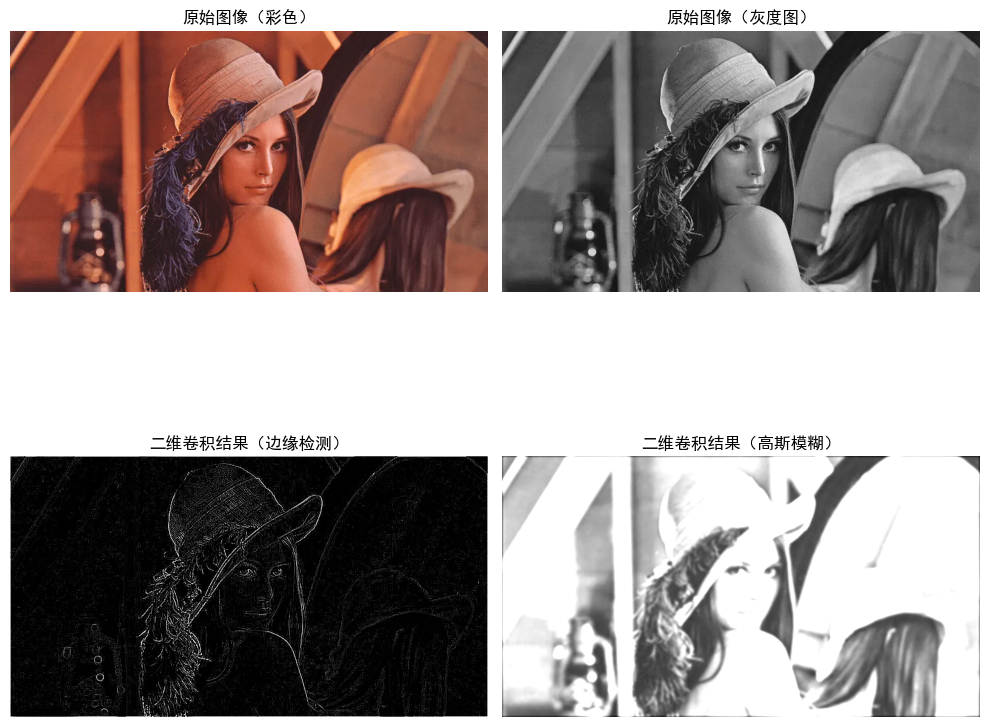

In [39]:
# 可视化：2行2列子图（彩色原图 + 灰度图 + 边缘检测 + 高斯模糊）
plt.figure(figsize=(10, 10))  # 调整画布尺寸，适配2x2布局，更协调

# 子图1：原始彩色图像（已转换为 RGB 格式）
plt.subplot(2, 2, 1)  # 2行2列，第1个位置
plt.imshow(lena_color_rgb)
plt.title('原始图像（彩色）', fontsize=12)
plt.axis('off')

# 子图2：Lena 灰度图
plt.subplot(2, 2, 2)  # 2行2列，第2个位置
plt.imshow(lena_gray, cmap='gray')
plt.title('原始图像（灰度图）', fontsize=12)
plt.axis('off')

# 子图3：边缘检测卷积结果
plt.subplot(2, 2, 3)  # 2行2列，第3个位置
plt.imshow(conv_edge, cmap='gray')
plt.title('二维卷积结果（边缘检测）', fontsize=12)
plt.axis('off')

# 子图4：高斯模糊卷积结果
plt.subplot(2, 2, 4)  # 2行2列，第4个位置
plt.imshow(conv_blur, cmap='gray')
plt.title('二维卷积结果（高斯模糊）', fontsize=12)
plt.axis('off')

# 调整子图间距，避免标题和图像重叠
plt.tight_layout()

# 显示可视化图表
plt.show()

In [40]:
import numpy as np
from scipy.signal import convolve2d

# 简单二维图像和卷积核
img = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.float32)
kernel = np.array([[1, 0], [0, 1]], dtype=np.float32)

# 直接调用卷积函数，自动完成翻转+卷积
conv_result = convolve2d(img, kernel, mode='valid')

print("输入图像：\n", img)
print("卷积核：\n", kernel)
print("卷积结果：\n", conv_result)

输入图像：
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
卷积核：
 [[1. 0.]
 [0. 1.]]
卷积结果：
 [[ 6.  8.]
 [12. 14.]]
